### 192.168.21.101(192.168.21.104)是Haptic Client  Camera server
### 192.168.21.102(192.168.21.127)是Camera Client
### 192.168.21.103(192.168.21.229)是Haptic Server

### camera 的延迟

In [129]:
import pandas as pd
from scapy.all import rdpcap, PacketList

def load_packets(filename):
    # 读取pcapng文件并返回PacketList
    return rdpcap(filename)

def extract_time_id_and_mark(packets):
    # 提取时间、ID code和mark位
    data = []
    for packet in packets:
        if 'IP' in packet and packet['IP'].src == '192.168.21.127' and packet['IP'].dst == '192.168.21.104':
            id_code = str(packet['IP'].id)  # 假设ID code存储在IP包的ID字段
            time = packet.time
            
            # 读取RTP包的mark位（假设RTP负载在UDP包内）
            if 'UDP' in packet:
                payload = bytes(packet['UDP'].payload)  # 获取RTP负载的原始字节
                if len(payload) >= 2:
                    mark = (payload[1] >> 7) & 0x01  # 获取第2个字节的最高位 (mark位)
                else:
                    mark = 0
                data.append((time, id_code, mark))

    df = pd.DataFrame(data, columns=['time', 'id_code', 'mark'])

    # 获取第一个时间戳
    first_timestamp = df['time'].iloc[0]

    # 筛选出第一个时间戳后15秒内的所有数据
    df_filtered = df[df['time'] > first_timestamp + 15]


    return df_filtered

def find_earliest_common_time(df1, df2):
    # 找到两个数据框中的最早共有时间
    earliest_time1 = df1['time'].min()
    earliest_time2 = df2['time'].min()
    return max(earliest_time1, earliest_time2)

def analyze_latency_and_losses(df1, df2, threshold=60):
    # 分析延迟和丢包



    min_common_time = find_earliest_common_time(df1, df2)
    df1 = df1[df1['time'] >= min_common_time]
    df2 = df2[df2['time'] >= min_common_time]

    # 创建id_code到时间的映射
    id_to_times = df2.groupby('id_code')['time'].apply(list).to_dict()

    results = {
        'client_time': [],
        'id_code': [],
        'latency': [],
        'status': [],
        'mark': []
    }

    # 遍历df1，查找匹配和计算延迟
    for index, row in df1.iterrows():
        id_code = row['id_code']
        client_time = row['time']
        mark_value = row['mark']
        if id_code in id_to_times:
            # 检查时间阈值内的匹配
            matched_times = [t for t in id_to_times[id_code] if client_time <= t <= client_time + threshold]
            if matched_times:
                latency = min(matched_times) - client_time
                results['latency'].append(latency)
                results['status'].append('Received')
            else:
                results['latency'].append(None)
                results['status'].append('Lost')
        else:
            results['latency'].append(None)
            results['status'].append('Lost')

        results['client_time'].append(client_time)
        results['id_code'].append(id_code)
        results['mark'].append(mark_value)

    return pd.DataFrame(results)

def calculate_loss_ratio(df):
    
    mark_one_rows = df[df['mark'] == 1]
    total_mark_ones = len(mark_one_rows)
    loss_count = 0

   
    mark_one_indices = mark_one_rows.index.tolist()

   
    for i in range(1, total_mark_ones):
    
        segment = df.loc[mark_one_indices[i-1]+1:mark_one_indices[i]-1]
        
        if any(segment['status'] == 'Lost'):
            loss_count += 1 

    
    if total_mark_ones > 1:
        loss_ratio = loss_count / float(total_mark_ones - 1)
    else:
        loss_ratio = 0.0  

    return loss_ratio



def calculate_successful_frames_per_second(df):

    df_copy = df.copy()

    # 创建一个存储每秒统计结果的字典
    frame_stats_per_second = {
        'second': [],
        'total_mark_ones': [],
        'lost_frames': [],
        'successful_frames': []
    }

    # 将时间戳转换为秒数
    df_copy['time_in_seconds'] = df_copy['client_time'].astype(int)

    # 逐秒分组
    grouped = df_copy.groupby('time_in_seconds')

    for second, group in grouped:
        # 获取当前秒内所有 mark=1 的帧
        mark_one_rows = group[group['mark'] == 1]
        total_mark_ones = len(mark_one_rows)
        loss_count = 0

        # 获取 mark=1 帧的索引
        mark_one_indices = mark_one_rows.index.tolist()

        # 计算丢失帧数
        for i in range(1, total_mark_ones):
            # 查找相邻 mark=1 帧之间是否有丢失帧
            segment = group.loc[mark_one_indices[i-1]+1:mark_one_indices[i]-1]
            if any(segment['status'] == 'Lost'):
                loss_count += 1

        # 计算成功发出的帧数
        successful_frames = total_mark_ones - loss_count

        # 记录当前秒的统计结果
        frame_stats_per_second['second'].append(second)
        frame_stats_per_second['total_mark_ones'].append(total_mark_ones)
        frame_stats_per_second['lost_frames'].append(loss_count)
        frame_stats_per_second['successful_frames'].append(successful_frames)

    # 将结果转换为 DataFrame
    return pd.DataFrame(frame_stats_per_second)


In [15]:
bandwidths = [10, 5, 3, 2.75, 2.5, 2.25, 2, 1.75, 1.5, 1.25, 1, 0.75, 0.5]
#bandwidths = [20, 15, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
base_path_101 = r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\101\codel_XDP_N\capture_{}_101.pcap"
base_path_102 = r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\102\codel_XDP_N\capture_{}_102.pcap"

# bandwidths = [1]

# base_path_101 = r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\101\capture_{}_101.pcap"
# base_path_102 = r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\102\capture_{}_102.pcap"

for bandwidth in bandwidths:
    file_path_camera_server = base_path_101.format(bandwidth)
    file_path_camera_client = base_path_102.format(bandwidth)

    packets1 = load_packets(file_path_camera_client)
    packets2 = load_packets(file_path_camera_server)

    df1 = extract_time_id_and_mark(packets1)
    df2 = extract_time_id_and_mark(packets2)

    result_df = analyze_latency_and_losses(df1, df2)

    result_df.to_csv(fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_N\camera\result_df_camera_{bandwidth}M.csv", index=False)

    frame_df = calculate_successful_frames_per_second(result_df)

    frame_df.to_csv(fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_N\camera\result_df_frame_{bandwidth}M.csv", index=False)

    del frame_df
    
    with open(fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_N\camera\latency_and_loss_stats_{bandwidth}.txt", "w") as file:
        if not result_df['latency'].isna().all():  # 确保至少有一个有效的延迟测量
            file.write("Latency Statistics:\n")
            file.write("Minimum Latency: {}\n".format(result_df['latency'].min()))
            file.write("Maximum Latency: {}\n".format(result_df['latency'].max()))
            file.write("Average Latency: {}\n".format(result_df['latency'].mean()))
        else:
            file.write("No valid latency measurements available.\n")

        # 计算丢包率
        total_packets = len(result_df)
        lost_packets = result_df[result_df['status'] == 'Lost'].shape[0]
        loss_rate = (lost_packets / total_packets) * 100

        file.write("Total Packets: {}\n".format(total_packets))
        file.write("Lost Packets: {}\n".format(lost_packets))
        file.write("Loss Rate: {:.2f}%\n".format(loss_rate))

        # 也可以选择性地写入result_df的头部
        file.write("\nFirst few rows of results DataFrame:\n")
        result_df_head = result_df.head().to_string()  # 将DataFrame转换为字符串
        file.write(result_df_head + "\n")

        # 如果需要，还可以保存mark的总和
        total_mark = df1['mark'].sum()
        file.write("Total Mark Count: {}\n".format(total_mark))

        # 计算丢失比例
        loss_ratio = calculate_loss_ratio(result_df)
        file.write("Loss Ratio between Mark=1 frames: {:.6f}\n".format(loss_ratio))

del packets1, packets2, df1, df2, result_df





In [130]:
bandwidths = [10, 5, 3, 2.75, 2.5, 2.25, 2, 1.75, 1.5, 1.25, 1, 0.75, 0.5]
dps = [0.7]
inss = [0.01]

base_path_101 = r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\101\pfifo_XDP_AIMD\capture_{}_{}_{}_101.pcap"
base_path_102 = r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\102\pfifo_XDP_AIMD\capture_{}_{}_{}_102.pcap"

# bandwidths = [1]

# base_path_101 = r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\101\capture_{}_101.pcap"
# base_path_102 = r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\102\capture_{}_102.pcap"

for dp in dps:
    for ins in inss:

        for bandwidth in bandwidths:
            file_path_camera_server = base_path_101.format(bandwidth,dp,ins)
            file_path_camera_client = base_path_102.format(bandwidth,dp,ins)

            packets1 = load_packets(file_path_camera_client)
            packets2 = load_packets(file_path_camera_server)

            df1 = extract_time_id_and_mark(packets1)
            df2 = extract_time_id_and_mark(packets2)

            result_df = analyze_latency_and_losses(df1, df2)

            result_df.to_csv(fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\pfifo_XDP_AIMD\camera\result_df_camera_{bandwidth}_{dp}_{ins}.csv", index=False)

            frame_df = calculate_successful_frames_per_second(result_df)

            frame_df.to_csv(fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\pfifo_XDP_AIMD\camera\result_df_frame_{bandwidth}_{dp}_{ins}.csv", index=False)

            del frame_df
            
            with open(fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\pfifo_XDP_AIMD\camera\latency_and_loss_stats_{bandwidth}_{dp}_{ins}.txt", "w") as file:
                if not result_df['latency'].isna().all():  # 确保至少有一个有效的延迟测量
                    file.write("Latency Statistics:\n")
                    file.write("Minimum Latency: {}\n".format(result_df['latency'].min()))
                    file.write("Maximum Latency: {}\n".format(result_df['latency'].max()))
                    file.write("Average Latency: {}\n".format(result_df['latency'].mean()))
                else:
                    file.write("No valid latency measurements available.\n")

                # 计算丢包率
                total_packets = len(result_df)
                lost_packets = result_df[result_df['status'] == 'Lost'].shape[0]
                loss_rate = (lost_packets / total_packets) * 100

                file.write("Total Packets: {}\n".format(total_packets))
                file.write("Lost Packets: {}\n".format(lost_packets))
                file.write("Loss Rate: {:.2f}%\n".format(loss_rate))

                # 也可以选择性地写入result_df的头部
                file.write("\nFirst few rows of results DataFrame:\n")
                result_df_head = result_df.head().to_string()  # 将DataFrame转换为字符串
                file.write(result_df_head + "\n")

                # 如果需要，还可以保存mark的总和
                total_mark = df1['mark'].sum()
                file.write("Total Mark Count: {}\n".format(total_mark))

                # 计算丢失比例
                loss_ratio = calculate_loss_ratio(result_df)
                file.write("Loss Ratio between Mark=1 frames: {:.6f}\n".format(loss_ratio))

del packets1, packets2, df1, df2, result_df





In [ ]:
result_df = analyze_latency_and_losses(df1, df2)
#print(result_df)

# 打印统计结果
if not result_df['latency'].isna().all():  # 确保至少有一个有效的延迟测量
    print("Latency Statistics:")
    print("Minimum Latency:", result_df['latency'].min())
    print("Maximum Latency:", result_df['latency'].max())
    print("Average Latency:", result_df['latency'].mean())
else:
    print("No valid latency measurements available.")

# 计算丢包率
total_packets = len(result_df)
lost_packets = result_df[result_df['status'] == 'Lost'].shape[0]
loss_rate = (lost_packets / total_packets) * 100

print("Total Packets:", total_packets)
print("Lost Packets:", lost_packets)
print("Loss Rate: {:.2f}%".format(loss_rate))

# 选择性打印result_df的头部，便于查看数据结构
print(result_df.head())
print(df1['mark'].sum())
calculate_loss_ratio(result_df)



In [7]:
def analyze_per_second(df):
    # 确保时间戳以秒为单位
    df['second'] = df['client_time'].apply(lambda x: int(x))
    
    # 分组计算每秒的平均延迟和丢包率
    grouped = df.groupby('second')
    stats_per_second = grouped.agg(
        average_latency=('latency', 'mean'),
        total_packets=('id_code', 'count'),
        received_packets=('status', lambda x: (x == 'Received').sum()),
        lost_packets=('status', lambda x: (x == 'Lost').sum())
    )
    
    # 计算丢包率
    stats_per_second['loss_rate'] = stats_per_second['lost_packets'] / stats_per_second['total_packets']
    
    # 返回处理后的数据框
    return stats_per_second

import matplotlib.pyplot as plt

def plot_latency_and_loss_separately(df_stats, latency_path, ploss_path):
    # 检查是否有足够的数据进行绘图
    if df_stats.empty:
        print("No data available to plot.")
        return

    # 绘制延迟图
    plt.figure(figsize=(10, 5))
    plt.scatter(df_stats.index, df_stats['average_latency'], color='tab:red')
    plt.title('Average Latency Per Second')
    plt.xlabel('Second')
    plt.ylabel('Average Latency (s)')
    plt.grid(True)
    plt.savefig(latency_path)
    plt.show()

    # 绘制丢包率图
    plt.figure(figsize=(10, 5))
    plt.scatter(df_stats.index, df_stats['loss_rate'], color='tab:blue')
    plt.title('Loss Rate Per Second')
    plt.xlabel('Second')
    plt.ylabel('Loss Rate')
    plt.grid(True)
    plt.savefig(ploss_path)
    plt.show()


In [8]:
#df_stats = analyze_per_second(result_df)
# plot_latency_and_loss_separately(df_stats,latency_path=path1,ploss_path=path2)

### Haptic Deadband parameter 分布

In [58]:
from scapy.all import rdpcap
import matplotlib.pyplot as plt
from collections import Counter

# 读取 pcapng 文件
def read_pcapng(file_path):
    packets = rdpcap(file_path)
    return packets

# 提取 UDP 负载中的第一个字节，并转换为十进制数
def extract_udp_payload_first_byte(packets):
    first_byte_list = []
    for packet in packets:
        if packet.haslayer('UDP'):
            udp_payload = bytes(packet['UDP'].payload)
            if len(udp_payload) >= 1:
                # 提取第一个字节并转为十进制
                first_byte = udp_payload[0]
                first_byte_list.append(first_byte)


    
    return first_byte_list

# 计算第一个字节的分布
def calculate_distribution(first_byte_list):
    counter = Counter(first_byte_list)
    total = sum(counter.values())
    distribution = {k: v / total for k, v in counter.items()}
    return distribution

# 绘制分布比例图
def plot_distribution(distribution):
    keys = sorted(distribution.keys())
    values = [distribution[k] for k in keys]
    
    plt.figure(figsize=(10, 6))
    plt.bar(keys, values)
    plt.xlabel('First Byte of UDP Payload (Decimal)')
    plt.ylabel('Proportion')
    plt.title('Distribution of the First Byte of UDP Payload (in Decimal)')
    plt.xticks(keys)  # 使用十进制的字节值作为X轴刻度
    plt.tight_layout()
    plt.show()

# 主程序
file_path = r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\090501\haptic_client_filter.pcapng'  # 替换为你的pcapng文件路径
packets = read_pcapng(file_path)
first_byte_list = extract_udp_payload_first_byte(packets)
distribution = calculate_distribution(first_byte_list)
plot_distribution(distribution)


KeyboardInterrupt: 

### Haptic 丢包
### 以及Haptic Deadband parameter的变化

In [126]:
import pandas as pd
from scapy.all import rdpcap, PacketList

def load_packets(filename):
    # 读取pcapng文件并返回PacketList
    return rdpcap(filename)

def extract_time_id_and_deadband(packets):
    # 提取时间、ID code和mark位
    data = []
    for packet in packets:
        if 'IP' in packet and packet['IP'].src == '192.168.21.229' and packet['IP'].dst == '192.168.21.104':
            id_code = str(packet['IP'].id)  # 假设ID code存储在IP包的ID字段
            time = packet.time
            
            # 读取RTP包的mark位（假设RTP负载在UDP包内）
            if 'UDP' in packet:
                payload = bytes(packet['UDP'].payload)  # 获取RTP负载的原始字节
                if len(payload) >= 1:
                    deadband = payload[0]  # 获取第2个字节的最高位 (mark位)
                else:
                    deadband = 0
                data.append((time, id_code, deadband))

    df = pd.DataFrame(data, columns=['time', 'id_code', 'deadband'])


    first_timestamp = df['time'].iloc[0]


    df_filtered = df[df['time'] > first_timestamp + 15]

    
    return df_filtered

def find_earliest_common_time(df1, df2):
    # 找到两个数据框中的最早共有时间
    earliest_time1 = df1['time'].min()
    earliest_time2 = df2['time'].min()
    return max(earliest_time1, earliest_time2)

def analyze_latency_and_losses(df1, df2, threshold=20):
    # 分析延迟和丢包
    min_common_time = find_earliest_common_time(df1, df2)
    df1 = df1[df1['time'] >= min_common_time]
    df2 = df2[df2['time'] >= min_common_time]

    # 创建id_code到时间的映射
    id_to_times = df2.groupby('id_code')['time'].apply(list).to_dict()

    results = {
        'client_time': [],
        'id_code': [],
        'latency': [],
        'status': [],
        'deadband': []
    }

    # 遍历df1，查找匹配和计算延迟
    for index, row in df1.iterrows():
        id_code = row['id_code']
        client_time = row['time']
        deadband_value = row['deadband']
        if id_code in id_to_times:
            # 检查时间阈值内的匹配
            matched_times = [t for t in id_to_times[id_code] if client_time <= t <= client_time + threshold]
            if matched_times:
                latency = min(matched_times) - client_time
                results['latency'].append(latency)
                results['status'].append('Received')
            else:
                results['latency'].append(None)
                results['status'].append('Lost')
        else:
            results['latency'].append(None)
            results['status'].append('Lost')

        results['client_time'].append(client_time)
        results['id_code'].append(id_code)
        results['deadband'].append(deadband_value)

    return pd.DataFrame(results)





In [ ]:
bandwidths = [20, 15, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

server_path = r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\101\without_TC\capture_{}_101.pcap"
client_path = r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\103\without_TC\capture_{}_103.pcap"


for bandwidth in bandwidths:
    file_path_camera_server = server_path.format(bandwidth)
    file_path_camera_client = client_path.format(bandwidth)

    packets1 = load_packets(file_path_camera_client)
    packets2 = load_packets(file_path_camera_server)

    df1 = extract_time_id_and_deadband(packets1)
    df2 = extract_time_id_and_deadband(packets2)

    result_df = analyze_latency_and_losses(df1, df2)

    result_df.to_csv(fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\without_TC\haptic\result_df_haptic_{bandwidth}M.csv", index=False)
                        
    
    with open(fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\without_TC\haptic\latency_and_loss_stats_{bandwidth}.txt", "w") as file:
        if not result_df['latency'].isna().all():  # 确保至少有一个有效的延迟测量
            file.write("Latency Statistics:\n")
            file.write("Minimum Latency: {}\n".format(result_df['latency'].min()))
            file.write("Maximum Latency: {}\n".format(result_df['latency'].max()))
            file.write("Average Latency: {}\n".format(result_df['latency'].mean()))
        else:
            file.write("No valid latency measurements available.\n")

        # 计算丢包率
        total_packets = len(result_df)
        lost_packets = result_df[result_df['status'] == 'Lost'].shape[0]
        loss_rate = (lost_packets / total_packets) * 100

        file.write("Total Packets: {}\n".format(total_packets))
        file.write("Lost Packets: {}\n".format(lost_packets))
        file.write("Loss Rate: {:.2f}%\n".format(loss_rate))

        # 也可以选择性地写入result_df的头部
        file.write("\nFirst few rows of results DataFrame:\n")
        result_df_head = result_df.head().to_string()  # 将DataFrame转换为字符串
        file.write(result_df_head + "\n")









In [128]:

bandwidths = [10, 5, 3, 2.75, 2.5, 2.25, 2, 1.75, 1.5, 1.25, 1, 0.75, 0.5]
dps = [0.7]
inss = [0.01]


server_path = r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\101\pfifo_XDP_AIMD\capture_{}_{}_{}_101.pcap"
client_path = r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\103\pfifo_XDP_AIMD\capture_{}_{}_{}_103.pcap"


for dp in dps:
    for ins in inss:

        for bandwidth in bandwidths:
            file_path_camera_server = server_path.format(bandwidth,dp,ins)
            file_path_camera_client = client_path.format(bandwidth,dp,ins)

            packets1 = load_packets(file_path_camera_client)
            packets2 = load_packets(file_path_camera_server)

            df1 = extract_time_id_and_deadband(packets1)
            df2 = extract_time_id_and_deadband(packets2)

            result_df = analyze_latency_and_losses(df1, df2)

            result_df.to_csv(fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\pfifo_XDP_AIMD\haptic\result_df_haptic_{bandwidth}_{dp}_{ins}.csv", index=False)
                                
            
            with open(fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\pfifo_XDP_AIMD\haptic\latency_and_loss_stats_{bandwidth}_{dp}_{ins}.txt", "w") as file:
                if not result_df['latency'].isna().all():  # 确保至少有一个有效的延迟测量
                    file.write("Latency Statistics:\n")
                    file.write("Minimum Latency: {}\n".format(result_df['latency'].min()))
                    file.write("Maximum Latency: {}\n".format(result_df['latency'].max()))
                    file.write("Average Latency: {}\n".format(result_df['latency'].mean()))
                else:
                    file.write("No valid latency measurements available.\n")

                # 计算丢包率
                total_packets = len(result_df)
                lost_packets = result_df[result_df['status'] == 'Lost'].shape[0]
                loss_rate = (lost_packets / total_packets) * 100

                file.write("Total Packets: {}\n".format(total_packets))
                file.write("Lost Packets: {}\n".format(lost_packets))
                file.write("Loss Rate: {:.2f}%\n".format(loss_rate))

                # 也可以选择性地写入result_df的头部
                file.write("\nFirst few rows of results DataFrame:\n")
                result_df_head = result_df.head().to_string()  # 将DataFrame转换为字符串
                file.write(result_df_head + "\n")









### camera 帧率

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


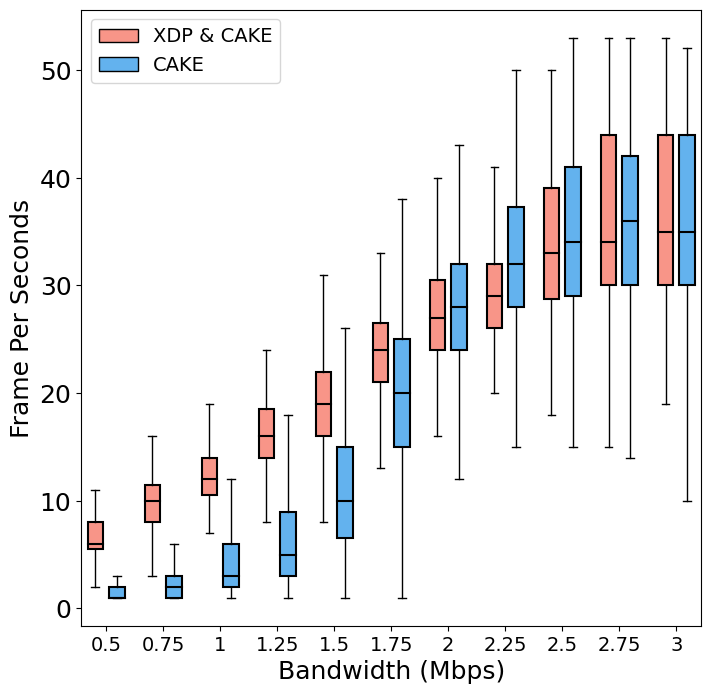

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# List of bandwidths for the filenames
#bandwidths = [10, 5, 3, 2.75, 2.5, 2.25, 2, 1.75, 1.5, 1.25, 1, 0.75, 0.5]
bandwidths = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]
# Initialize empty lists to store the 'successful_frames' data from each file for both sets
successful_frames_data_fq_codel = []
successful_frames_data_codel = []

# Loop over each bandwidth to read the respective CSV files for both fq_codel and codel
for num in bandwidths:
    # File paths for the two sets of files
    # with_XDP = fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\cake_XDP\camera\result_df_frame_{num}M.csv"
    # without_XDP = fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\tc_control\result\cake\camera\result_df_frame_{num}M.csv"

    with_XDP = fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\cake_XDP_AIMD\camera\result_df_frame_{num}_0.7_0.01.csv"
    without_XDP = fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\tc_control\result\cake\camera\result_df_frame_{num}M.csv"

    
    # Read the fq_codel CSV file
    try:
        df_fq_codel = pd.read_csv(with_XDP)
        # Extract the 'successful_frames' column and append to the list
        successful_frames_data_fq_codel.append(df_fq_codel['successful_frames'])
    except FileNotFoundError:
        print(f"File {with_XDP} not found. Skipping.")
    
    # Read the codel CSV file
    try:
        df_codel = pd.read_csv(without_XDP)
        # Extract the 'successful_frames' column and append to the list
        successful_frames_data_codel.append(df_codel['successful_frames'])
    except FileNotFoundError:
        print(f"File {without_XDP} not found. Skipping.")

# Prepare to plot boxplots for both datasets
plt.figure(figsize=(8, 8))

# Combine data for plotting; each bandwidth has two boxplots side-by-side
combined_data = []
colors = []

# Create new positions with slightly larger distances for pairs
positions = []
main_spacing = 4  # Spacing between each bandwidth group
pair_offset = 1.5   # Offset within each pair (increased spacing)

for i in range(len(bandwidths)):
    # For each bandwidth, add two positions: one for FQ_CoDel and one for FQ_CoDel&XDP
    positions.append(i * main_spacing + 1)  # First boxplot for this bandwidth
    positions.append(i * main_spacing + 1 + pair_offset)  # Second boxplot for this bandwidth, slightly offset

    # Append corresponding data
    combined_data.append(successful_frames_data_fq_codel[i])
    combined_data.append(successful_frames_data_codel[i])
    
    # Colors: fq_codel in blue and codel in orange
    colors.append('#f89588')  # fq_codel
    colors.append('#63b2ee')  # codel

# Plotting the combined boxplots
boxprops = dict(linewidth=1.5, facecolor='white')  # Outline properties for boxplots
medianprops = dict(color='black', linewidth=1.5)  # Median line properties
flierprops = dict(marker='x', color='yellow', markersize=0)

boxplot = plt.boxplot(combined_data, patch_artist=True, positions=positions, boxprops=boxprops, medianprops=medianprops, flierprops=flierprops, widths= 1.1)

# Set colors for each box
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Create custom legend
legend_elements = [Patch(facecolor='#f89588', edgecolor='black', label='XDP & CAKE'),
                   Patch(facecolor='#63b2ee', edgecolor='black', label='CAKE')]

# Add the legend to the plot
plt.legend(handles=legend_elements, loc='upper left', fontsize=14)

# Adjust x-ticks to show each bandwidth label in the middle of the pair of boxplots
plt.xticks([i * main_spacing + 1 + pair_offset / 2 for i in range(len(bandwidths))], [f'{i}' for i in bandwidths], fontsize=14)
x_min = min(positions) - 1  # 左边增加1个单位的空白
x_max = max(positions) + 1  # 右边增加1个单位的空白
plt.xlim(x_min, x_max)
# Set titles and labels
# plt.title("Effect of XDP on FPS")
plt.xlabel("Bandwidth (Mbps)", fontsize=18)
plt.ylabel("Frame Per Seconds", fontsize=18)
plt.yticks(fontsize=18)
plt.savefig(r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\figures\methods\cake_framerate.eps")
plt.savefig(r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\figures\methods\cake_framerate.png")

# Show the plot
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


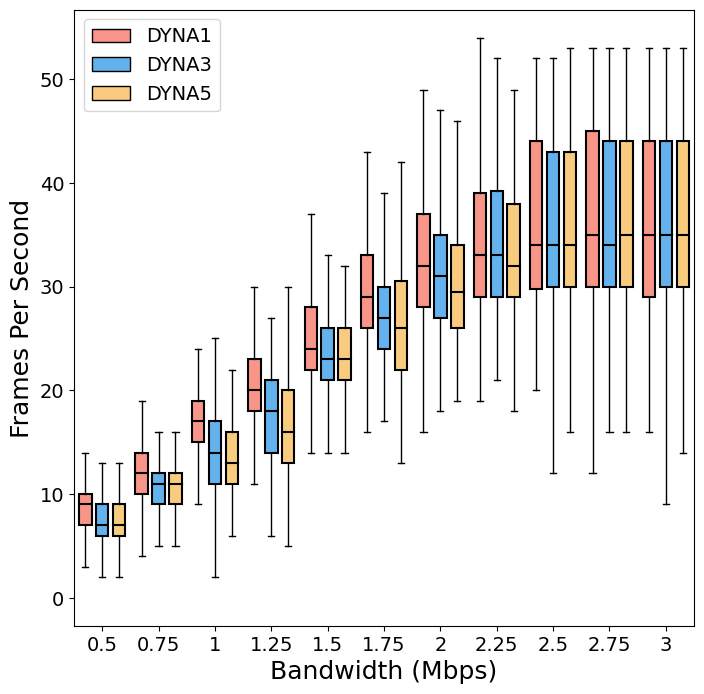

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# List of bandwidths for the filenames
bandwidths = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]
#bandwidths = [20, 15, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
# bandwidths = [1, 2, 3, 4, 5, 6]
# Initialize empty lists to store the 'successful_frames' data from each file for all three paths
successful_frames_data_fq_codel = []
successful_frames_data_codel = []
successful_frames_data_third_path = []  # New list for the third path

# Loop over each bandwidth to read the respective CSV files for all three configurations
for num in bandwidths:
    # File paths for the three sets of files

    # with_XDP = fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\pfifo_XDP_AIMD\camera\result_df_frame_{num}_0.7_0.01.csv" 
    # without_XDP = fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_AIMD\camera\0.7\result_df_frame_{num}_0.7_0.01.csv"
    # third_path =    fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\cake_XDP_AIMD\camera\result_df_frame_{num}_0.7_0.01.csv"

    with_XDP = fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_DYNA\camera\0.01\result_df_frame_{num}_0.01_0.01M.csv"
    without_XDP = fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_DYNA\camera\0.03\result_df_frame_{num}_0.03_0.01M.csv"
    third_path = fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_DYNA\camera\0.05\result_df_frame_{num}_0.05_0.01M.csv"

    # Read the fq_codel (with_XDP) CSV file
    try:
        df_fq_codel = pd.read_csv(with_XDP)
        successful_frames_data_fq_codel.append(df_fq_codel['successful_frames'])
    except FileNotFoundError:
        print(f"File {with_XDP} not found. Skipping.")

    # Read the codel (without_XDP) CSV file
    try:
        df_codel = pd.read_csv(without_XDP)
        successful_frames_data_codel.append(df_codel['successful_frames'])
    except FileNotFoundError:
        print(f"File {without_XDP} not found. Skipping.")

    # Read the third path CSV file
    try:
        df_third_path = pd.read_csv(third_path)
        successful_frames_data_third_path.append(df_third_path['successful_frames'])
    except FileNotFoundError:
        print(f"File {third_path} not found. Skipping.")

# Prepare to plot boxplots for all three datasets
plt.figure(figsize=(8, 8))

# Combine data for plotting; each bandwidth has three boxplots side-by-side
combined_data = []
colors = []

# Create new positions with larger distances for triplets
positions = []
main_spacing = 5  # Spacing between each bandwidth group
pair_offset = 1.5  # Offset to create spacing within each triplet of boxplots

for i in range(len(bandwidths)):
    # For each bandwidth, add three positions: one for CAKE & XDP, one for CAKE, and one for the third path
    positions.append(i * main_spacing + 1)  # First boxplot for this bandwidth (CAKE & XDP)
    positions.append(i * main_spacing + 1 + pair_offset)  # Second boxplot for this bandwidth (CAKE)
    positions.append(i * main_spacing + 1 + 2 * pair_offset)  # Third boxplot for this bandwidth (third path)

    # Append corresponding data
    combined_data.append(successful_frames_data_fq_codel[i])
    combined_data.append(successful_frames_data_codel[i])
    combined_data.append(successful_frames_data_third_path[i])

    # Colors for each set
    colors.append('#f89588')  # CAKE & XDP
    colors.append('#63b2ee')  # CAKE
    colors.append('#f8cb7f')  # Third path (new color)

# Plotting the combined boxplots
boxprops = dict(linewidth=1.5, facecolor='white')  # Outline properties for boxplots
medianprops = dict(color='black', linewidth=1.5)  # Median line properties
flierprops = dict(marker='x', color='yellow', markersize=0)

boxplot = plt.boxplot(combined_data, patch_artist=True, positions=positions,
                      boxprops=boxprops, medianprops=medianprops, flierprops=flierprops, widths=1.1)

# Set colors for each box
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Create custom legend
legend_elements = [
    Patch(facecolor='#f89588', edgecolor='black', label='DYNA1'),
    Patch(facecolor='#63b2ee', edgecolor='black', label='DYNA3'),
    Patch(facecolor='#f8cb7f', edgecolor='black', label='DYNA5')  # Third path in green
]

# Add the legend to the plot
plt.legend(handles=legend_elements, loc='upper left', fontsize=14)

# Adjust x-ticks to show each bandwidth label in the middle of the triplet of boxplots
plt.xticks([i * main_spacing + 1 + pair_offset for i in range(len(bandwidths))], [f'{i}' for i in bandwidths], fontsize=14)
plt.yticks(fontsize=14)

# Adjust x-axis limits for better spacing
x_min = min(positions) - 1  # Increase margin on the left
x_max = max(positions) + 1  # Increase margin on the right
plt.xlim(x_min, x_max)

# Set titles and labels
plt.xlabel("Bandwidth (Mbps)", fontsize=18)
plt.ylabel("Frames Per Second", fontsize=18)

plt.savefig(r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\figures\methods\DYNA_framerate.eps")
plt.savefig(r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\figures\methods\DYNA_framerate.png")
# Show the plot
plt.show()


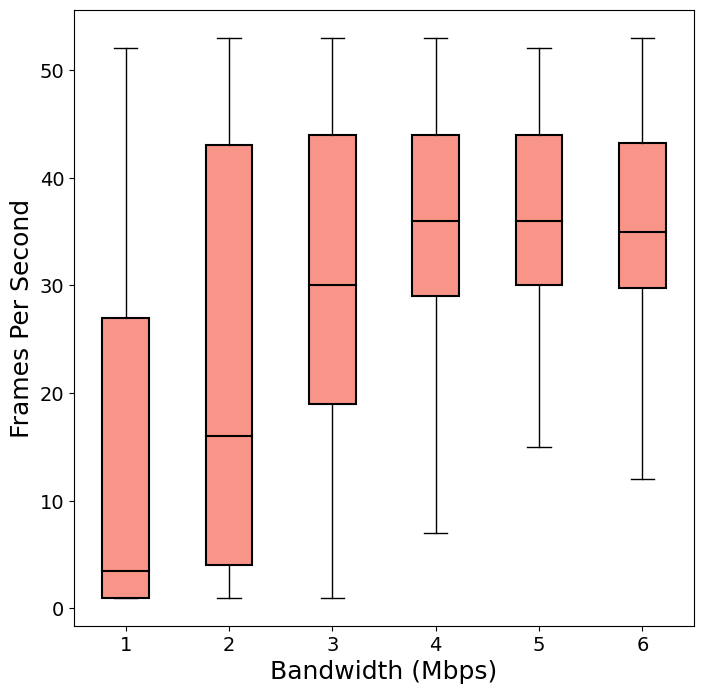

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# List of bandwidths for the filenames
#bandwidths = [20, 15, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
bandwidths = [1, 2, 3, 4, 5, 6]
# Initialize an empty list to store the 'successful_frames' data from each file for the set with XDP
successful_frames_data_fq_codel = []

# Loop over each bandwidth to read the respective CSV files for fq_codel with XDP
for num in bandwidths:
    # File path for the set with XDP
    with_XDP = fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\without_TC\camera\result_df_frame_{num}M.csv"
    
    # Read the fq_codel CSV file
    try:
        df_fq_codel = pd.read_csv(with_XDP)
        # Extract the 'successful_frames' column and append to the list
        successful_frames_data_fq_codel.append(df_fq_codel['successful_frames'])
    except FileNotFoundError:
        print(f"File {with_XDP} not found. Skipping.")

# Prepare to plot boxplots for the dataset
plt.figure(figsize=(8, 8))

# Plot the successful frames data for the fq_codel with XDP
boxprops = dict(linewidth=1.5, facecolor='white')  # Outline properties for boxplots
medianprops = dict(color='black', linewidth=1.5)  # Median line properties
flierprops = dict(marker='x', color='yellow', markersize=0)

# Plot the boxplots for each bandwidth
boxplot = plt.boxplot(successful_frames_data_fq_codel, patch_artist=True, boxprops=boxprops,
                      medianprops=medianprops, flierprops=flierprops, widths=0.45)

# Set colors for the boxplots
for patch in boxplot['boxes']:
    patch.set_facecolor('#f89588')

# Adjust x-ticks to represent each bandwidth
plt.xticks(range(1, len(bandwidths) + 1), [f'{i}' for i in bandwidths], fontsize = 14)
plt.yticks(fontsize = 14)
# Set titles and labels
#plt.title("Video FPS without TC Queue Management")
plt.xlabel("Bandwidth (Mbps)", fontsize = 18)
plt.ylabel("Frames Per Second", fontsize = 18)

plt.savefig(r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\figures\methods\without_TC_framerate.eps")
plt.savefig(r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\figures\methods\without_TC_framerate.png")

# Show the plot
plt.show()


### camera 延迟

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


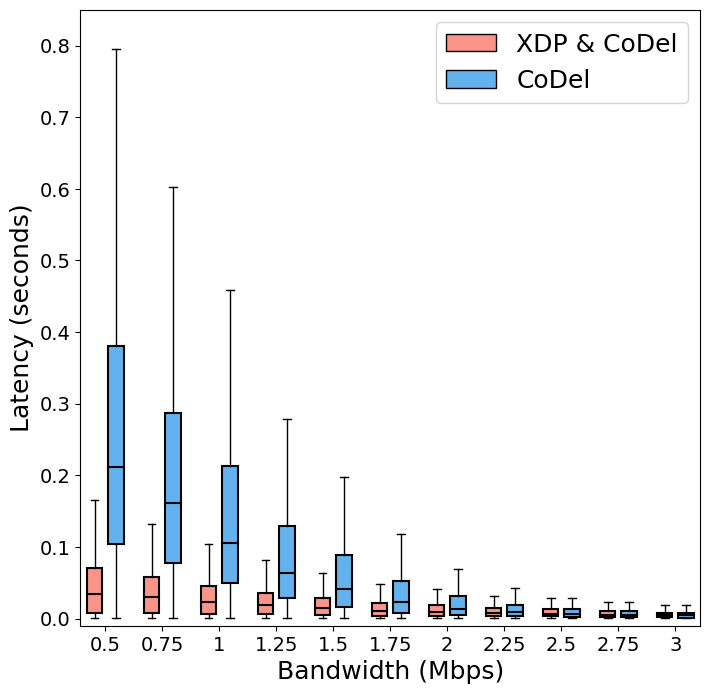

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# List of bandwidths for the filenames
bandwidths = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]
# bandwidths = [1, 2, 3, 4, 5, 6]
#bandwidths = [1, 2, 3, 4, 5, 6]
# Initialize empty lists to store the 'latency' data from each file for both sets
latency_data_fq_codel = []
latency_data_codel = []

# Loop over each bandwidth to read the respective CSV files for both fq_codel and codel
for num in bandwidths:
    # File paths for the two sets of files
    # with_XDP = fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\cake_XDP_AIMD\camera\result_df_camera_{num}_0.7_0.01.csv"
    # without_XDP = fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\tc_control\result\cake\camera\result_df_camera_{num}M.csv"
    
    with_XDP = fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_AIMD\camera\0.7\result_df_camera_{num}_0.7_0.01.csv"
    without_XDP = fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\tc_control\result\codel\camera\result_df_camera_{num}M.csv"
    # Read the fq_codel CSV file
    try:
        df_fq_codel = pd.read_csv(with_XDP)
        # Filter out rows where status is 'lost' and only include rows with status 'Received'
        filtered_fq_codel = df_fq_codel[df_fq_codel['status'] == 'Received']
        # Extract the 'latency' column and append to the list
        latency_data_fq_codel.append(filtered_fq_codel['latency'])
    except FileNotFoundError:
        print(f"File {with_XDP} not found. Skipping.")
    
    # Read the codel CSV file
    try:
        df_codel = pd.read_csv(without_XDP)
        # Filter out rows where status is 'lost' and only include rows with status 'Received'
        filtered_codel = df_codel[df_codel['status'] == 'Received']
        # Extract the 'latency' column and append to the list
        latency_data_codel.append(filtered_codel['latency'])
    except FileNotFoundError:
        print(f"File {without_XDP} not found. Skipping.")

# Prepare to plot boxplots for both datasets
plt.figure(figsize=(8, 8))

# Combine data for plotting; each bandwidth has two boxplots side-by-side
combined_data = []
colors = []

# Create new positions with larger distances between different bandwidth groups
positions = []
main_spacing = 4  # Increased spacing between each bandwidth group
pair_offset = 1.5  # Offset to create a gap within each pair of boxplots

for i in range(len(bandwidths)):
    # For each bandwidth, add two positions: one for FQ_CoDel&XDP and one for FQ_CoDel
    positions.append(i * main_spacing + 1)  # First boxplot for this bandwidth
    positions.append(i * main_spacing + 1 + pair_offset)  # Second boxplot for this bandwidth

    # Append corresponding data
    combined_data.append(latency_data_fq_codel[i])
    combined_data.append(latency_data_codel[i])
    
    # Colors: fq_codel in blue and codel in orange
    colors.append('#f89588')  # fq_codel
    colors.append('#63b2ee')  # codel

# Plotting the combined boxplots with increased width
boxprops = dict(linewidth=1.5, facecolor='white')  # Outline properties for boxplots
medianprops = dict(color='black', linewidth=1.5)  # Median line properties
flierprops = dict(marker='.', markerfacecolor='red', markeredgecolor='red', markersize=0)

# Set the width of the boxplots
box_width = 1.1

boxplot = plt.boxplot(combined_data, patch_artist=True, positions=positions, boxprops=boxprops,
                      medianprops=medianprops, flierprops=flierprops, widths=box_width, showfliers=True)

# Set colors for each box
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Create custom legend
legend_elements = [Patch(facecolor='#f89588', edgecolor='black', label='XDP & CoDel'),
                   Patch(facecolor='#63b2ee', edgecolor='black', label='CoDel')]

# Add the legend to the plot
plt.legend(handles=legend_elements, loc='upper right', fontsize = 18)

# Adjust x-ticks to make labels appear in the middle of the pair of boxplots for each bandwidth
plt.xticks([i * main_spacing + 1 + pair_offset / 2 for i in range(len(bandwidths))], [f'{i}' for i in bandwidths], fontsize = 14)

x_min = min(positions) - 1  # 左边增加1个单位的空白
x_max = max(positions) + 1  # 右边增加1个单位的空白
plt.xlim(x_min, x_max)
plt.ylim(-0.01, 0.85)
# Set titles and labels
#plt.title("Effect of P controller on Latency")
plt.xlabel("Bandwidth (Mbps)", fontsize = 18)
plt.ylabel("Latency (seconds)", fontsize = 18)

plt.yticks(fontsize = 14)

plt.savefig(r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\figures\methods\codel_latency.eps")
plt.savefig(r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\figures\methods\codel_latency.png")

# Show the plot
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


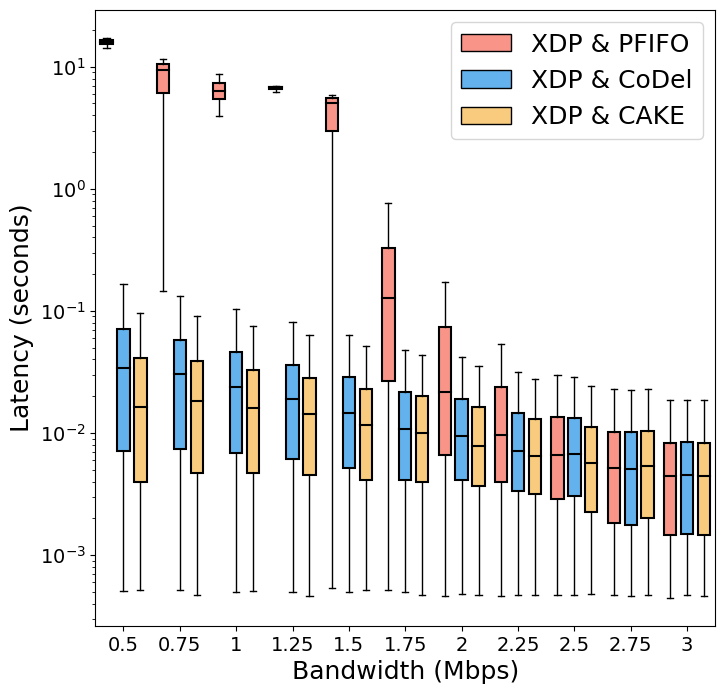

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import os

# List of bandwidths for the filenames
bandwidths = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]

# List of paths and labels for each path
paths = [
    (r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\pfifo_XDP_AIMD\camera\0.7", 'XDP & PFIFO'),

    (r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_AIMD\camera\0.7", 'XDP & CoDel'),

    (r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\cake_XDP_AIMD\camera\0.7", 'XDP & CAKE')
    # Add more paths as needed
]

# Define colors for each path
colors = ['#f89588', '#63b2ee', '#f8cb7f']  # Add more colors if needed

# Initialize a dictionary to store latency data for each path
latency_data = {label: [] for _, label in paths}

# Loop over each bandwidth to read the respective CSV files for each path
for num in bandwidths:
    for path, label in paths:
        # Corrected file path construction
        file_path_with_m = fr"{path}\result_df_camera_{num}_{path.split(os.sep)[-1]}_0.01M.csv"
        file_path_without_m = fr"{path}\result_df_camera_{num}_{path.split(os.sep)[-1]}_0.01.csv"

        # 检查文件是否存在
        if os.path.exists(file_path_with_m):
            file_path = file_path_with_m
        elif os.path.exists(file_path_without_m):
            file_path = file_path_without_m

        # Read the CSV file and filter for 'Received' status
        try:
            df = pd.read_csv(file_path)
            filtered_df = df[df['status'] == 'Received']
            latency_data[label].append(filtered_df['latency'])
        except FileNotFoundError:
            print(f"File {file_path} not found. Skipping.")

# Prepare to plot boxplots for each dataset
plt.figure(figsize=(8, 8))

# Combine data for plotting; each bandwidth has a boxplot for each path
combined_data = []
positions = []

# Set spacing parameters
main_spacing = 5
pair_offset = 1.5

# Create positions and data for each bandwidth and path
for i in range(len(bandwidths)):
    for j, (path, label) in enumerate(paths):
        # Calculate positions for each path in the current bandwidth group
        positions.append(i * main_spacing + 1 + j * pair_offset)
        combined_data.append(latency_data[label][i])

# Plot the boxplots
boxprops = dict(linewidth=1.5, facecolor='white')
medianprops = dict(color='black', linewidth=1.5)
flierprops = dict(marker='.', markerfacecolor='red', markeredgecolor='red', markersize=0)

box_width = 1.1
boxplot = plt.boxplot(combined_data, patch_artist=True, positions=positions, boxprops=boxprops,
                      medianprops=medianprops, flierprops=flierprops, widths=box_width, showfliers=True)

# Set colors for each boxplot
for patch, color in zip(boxplot['boxes'], colors * len(bandwidths)):
    patch.set_facecolor(color)

# Create legend based on labels
legend_elements = [Patch(facecolor=color, edgecolor='black', label=label) for color, (_, label) in zip(colors, paths)]
plt.legend(handles=legend_elements, loc='upper right',fontsize=18)
plt.yscale('log')
# Set x-ticks to be in the middle of each bandwidth group
plt.xticks([i * main_spacing + 1 + pair_offset for i in range(len(bandwidths))], [f'{i}' for i in bandwidths], fontsize=14)
plt.yticks(fontsize=14)
# Adjust x and y axis limits
x_min = min(positions) - 1
x_max = max(positions) + 1
plt.xlim(x_min, x_max)
# plt.ylim(-0.01, 0.2)

# Set titles and labels
plt.xlabel("Bandwidth (Mbps)", fontsize=18)
plt.ylabel("Latency (seconds)", fontsize=18)
plt.savefig(r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\figures\methods\between_aqm_latency.eps")
plt.savefig(r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\figures\methods\between_aqm_latency.png")
# Show the plot
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


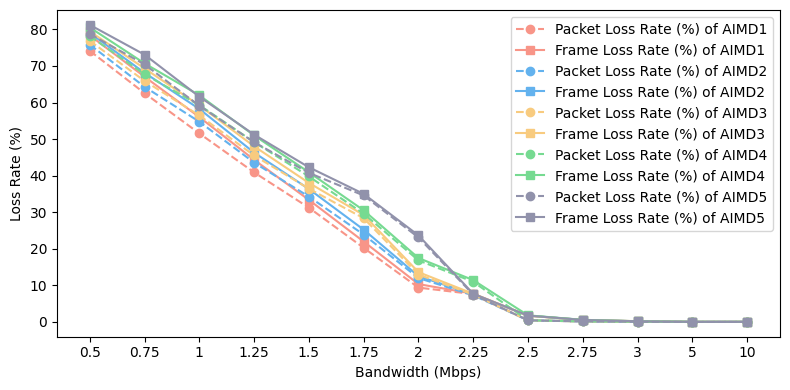

In [25]:
import os
import re
import matplotlib.pyplot as plt

def plot_combined_loss_rate_and_ratio(paths, path_names):
    plt.figure(figsize=(8, 4))
    
    # Define a custom color list
    color_list = [
        "#f89588", "#63b2ee", "#f8cb7f", "#76da91", "#9192ab",
        "#9192ab", "#7898e1", "#efa666", "#eddd86", "#9987ce",
    ]

    for idx, (path, path_name) in enumerate(zip(paths, path_names)):
        # Extracting a specific part of the path for the legend
        files = sorted(
            [f for f in os.listdir(path) if re.match(r'latency_and_loss_stats_.*\.txt', f)],
            key=lambda x: float(x.split('_')[4])  # 提取第一个数字并转为浮点数
        )
        loss_rates = []
        loss_ratios = []
        x_labels = []

        # Get the color from the predefined list using modulo in case we have more paths than colors
        color = color_list[idx % len(color_list)]

        for file in sorted(files, key=lambda x: float(x.split('_')[-1].replace('.txt', ''))):
            file_path = os.path.join(path, file)
            with open(file_path, 'r') as f:
                content = f.read()

            # Extracting loss rate and loss ratio
            loss_rate_match = re.search(r'Loss Rate: ([\d.]+)%', content)
            loss_ratio_match = re.search(r'Loss Ratio between Mark=1 frames: ([\d.]+)', content)

            # Check if either loss rate or loss ratio exists
            if loss_rate_match or loss_ratio_match:
                x_labels.append(file.split('_')[-3].replace('.txt', ''))

                if loss_rate_match:
                    loss_rate = float(loss_rate_match.group(1))
                    loss_rates.append(loss_rate)
                else:
                    loss_rates.append(None)  # If loss rate not found, keep it empty

                if loss_ratio_match:
                    loss_ratio = float(loss_ratio_match.group(1)) * 100  # Converting loss ratio to percentage
                    loss_ratios.append(loss_ratio)
                else:
                    loss_ratios.append(None)  # If loss ratio not found, keep it empty

        # Plot the available loss rate and/or loss ratio with the same color
        if any(lr is not None for lr in loss_rates):
            plt.plot(
                x_labels,
                [lr if lr is not None else 0 for lr in loss_rates],  # 将 None 替换为 0
                marker='o',
                linestyle='--',
                color=color,  # 使用颜色列表中的颜色
                label=f'Packet Loss Rate (%) of {path_name}'
            )

        if any(loss_ratios):
            plt.plot(
                x_labels,
                [lr for lr in loss_ratios if lr is not None],
                marker='s',  
                linestyle='-',  
                color=color,  # Use the color from the list
                label=f'Frame Loss Rate (%) of {path_name}'
            )

    plt.xlabel('Bandwidth (Mbps)')
    plt.ylabel('Loss Rate (%)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\figures\methods\AIMD_lossrate1.eps")
    plt.savefig(r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\figures\methods\AIMD_lossrate1.png")
    plt.show()


# Usage
paths = [
    r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_AIMD\camera\0.9",
    r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_AIMD\camera\0.8",
    r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_AIMD\camera\0.7",
    r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_AIMD\camera\0.6",
    r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_AIMD\camera\0.5"
    
]

# Define names for each path
path_names = ["AIMD1", "AIMD2", "AIMD3", "AIMD4", "AIMD5"]

plot_combined_loss_rate_and_ratio(paths, path_names)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


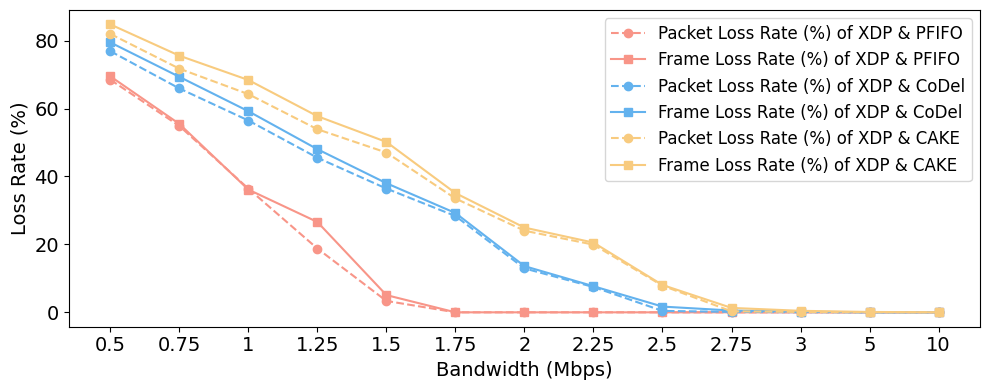

In [81]:
import os
import re
import matplotlib.pyplot as plt

def plot_combined_loss_rate_and_ratio(paths, path_names):
    plt.figure(figsize=(10, 4))
    
    # Define a custom color list
    color_list = [
        "#f89588", "#63b2ee", "#f8cb7f", "#76da91", "#9192ab",
        "#9192ab", "#7898e1", "#efa666", "#eddd86", "#9987ce",
    ]

    for idx, (path, path_name) in enumerate(zip(paths, path_names)):
        # Extracting a specific part of the path for the legend
        files = sorted(
            [f for f in os.listdir(path) if re.match(r'latency_and_loss_stats_.*\.txt', f)],
            key=lambda x: float(x.split('_')[4].replace('.txt', ''))  # 提取第一个数字并转为浮点数
        )
        loss_rates = []
        loss_ratios = []
        x_labels = []

        # Get the color from the predefined list using modulo in case we have more paths than colors
        color = color_list[idx % len(color_list)]

        for file in sorted(files, key=lambda x: float(x.split('_')[-1].replace('.txt', ''))):
            file_path = os.path.join(path, file)
            with open(file_path, 'r') as f:
                content = f.read()

            # Extracting loss rate and loss ratio
            loss_rate_match = re.search(r'Loss Rate: ([\d.]+)%', content)
            loss_ratio_match = re.search(r'Loss Ratio between Mark=1 frames: ([\d.]+)', content)

            # Check if either loss rate or loss ratio exists
            if loss_rate_match or loss_ratio_match:

                x_labels.append(file.split('_')[4].replace('.txt', ''))

                if loss_rate_match:
                    loss_rate = float(loss_rate_match.group(1))
                    loss_rates.append(loss_rate)
                else:
                    loss_rates.append(None)  # If loss rate not found, keep it empty

                if loss_ratio_match:
                    loss_ratio = float(loss_ratio_match.group(1)) * 100  # Converting loss ratio to percentage
                    loss_ratios.append(loss_ratio)
                else:
                    loss_ratios.append(None)  # If loss ratio not found, keep it empty

        # Plot the available loss rate and/or loss ratio with the same color
        if any(lr is not None for lr in loss_rates):
            plt.plot(
                x_labels,
                [lr if lr is not None else 0 for lr in loss_rates],  # 将 None 替换为 0
                marker='o',
                linestyle='--',
                color=color,  # 使用颜色列表中的颜色
                label=f'Packet Loss Rate (%) of {path_name}'
            )

        if any(loss_ratios):
            plt.plot(
                x_labels,
                [lr for lr in loss_ratios if lr is not None],
                marker='s',  
                linestyle='-',  
                color=color,  # Use the color from the list
                label=f'Frame Loss Rate (%) of {path_name}'
            )

    plt.xlabel('Bandwidth (Mbps)', fontsize = 14)
    plt.ylabel('Loss Rate (%)', fontsize = 14)
    plt.legend(fontsize = 12)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.tight_layout()
    plt.savefig(r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\figures\methods\between_aqm_lossrate.eps")
    plt.savefig(r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\figures\methods\between_aqm_lossrate.png")

    plt.show()


# Usage
paths = [
    # r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_DYNA\camera\0.01",
    # r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_DYNA\camera\0.02",
    r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\pfifo_XDP_AIMD\camera\0.7",
    r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_AIMD\camera\0.7",
    # r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\tc_control\result\codel\camera",
    # r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_DYNA\camera\0.03",
    r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\cake_XDP_AIMD\camera\0.7",
    # r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\without_TC\camera",
    # r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\without_TC\haptic"
    # r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_DYNA\camera\0.04",
    # r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_DYNA\camera\0.05"
]

# Define names for each path
path_names = ["XDP & PFIFO", "XDP & CoDel", "XDP & CAKE", "DYNA4", "DYNA5"]

plot_combined_loss_rate_and_ratio(paths, path_names)


In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# List of bandwidths to process
bandwidths = [10, 5, 3, 2.75, 2.5, 2.25, 2, 1.75, 1.5, 1.25, 1, 0.75, 0.5]

# Base paths for files from two different sets (original and comparison)
camera_base_path_1 = r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\fq_codel_E_after15\camera\result_df_camera_{}M.csv'
haptic_base_path_1 = r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\fq_codel_E_after15\haptic\result_df_haptic_{}M.csv'

camera_base_path_2 = r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\tc_control\result\fq_codel\camera\result_df_camera_{}M.csv'
haptic_base_path_2 = r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\tc_control\result\fq_codel\haptic\result_df_haptic_{}M.csv'

# Dictionary to store differences for each bandwidth from both sets
all_differences_1 = []  # For set 1
all_differences_2 = []  # For set 2

# Function to process each set of files
def calculate_differences(camera_path_template, haptic_path_template, bandwidths):
    differences_list = []

    for bandwidth in bandwidths:
        # Load data for each bandwidth
        camera_path = camera_path_template.format(bandwidth)
        haptic_path = haptic_path_template.format(bandwidth)

        try:
            # Load data from CSV files
            camera_df = pd.read_csv(camera_path)
            haptic_df = pd.read_csv(haptic_path)

            # Convert client_time and latency to numeric for easier calculations
            camera_df['client_time'] = pd.to_numeric(camera_df['client_time'], errors='coerce')
            camera_df['latency'] = pd.to_numeric(camera_df['latency'], errors='coerce')
            haptic_df['client_time'] = pd.to_numeric(haptic_df['client_time'], errors='coerce')
            haptic_df['latency'] = pd.to_numeric(haptic_df['latency'], errors='coerce')

            # Identify sequences in the first file with no lost packets between two mark=1
            valid_sequences = []
            current_sequence = []
            include_sequence = False

            for index, row in camera_df.iterrows():
                if row['mark'] == 1:
                    if include_sequence:  # end the current sequence if valid
                        valid_sequences.append(current_sequence + [index])  # include the second mark=1
                    current_sequence = [index]  # start a new sequence
                    include_sequence = True
                else:
                    current_sequence.append(index)
                    if row['status'] == 'Lost':
                        include_sequence = False  # invalidate the current sequence if any packet is lost

            # Calculate differences for valid sequences
            differences = []

            for seq in valid_sequences:
                if len(seq) > 1:
                    # Take the client_time of the second mark=1
                    second_mark_index = seq[-1]
                    end_mark_time = camera_df.iloc[second_mark_index]['client_time']

                    # Find the closest haptic time within a 10ms window
                    mask = (haptic_df['client_time'] >= end_mark_time - 0.010) & (haptic_df['client_time'] <= end_mark_time + 0.010)
                    filtered_haptic_times = haptic_df[mask]

                    if not filtered_haptic_times.empty:
                        # Find the closest haptic time
                        closest_haptic_time_row = filtered_haptic_times.iloc[(filtered_haptic_times['client_time'] - end_mark_time).abs().argsort()[:1]]
                        haptic_client_time = closest_haptic_time_row['client_time'].values[0]
                        haptic_latency = closest_haptic_time_row['latency'].values[0]

                        # Calculate (client_time + latency) for both camera and haptic
                        camera_time_with_latency = camera_df.iloc[second_mark_index]['client_time'] + camera_df.iloc[second_mark_index]['latency']
                        haptic_time_with_latency = haptic_client_time + haptic_latency

                        # Calculate the absolute difference
                        time_difference = abs(camera_time_with_latency - haptic_time_with_latency)

                        # Add to differences only if the value is not NaN
                        if not np.isnan(time_difference):
                            differences.append(time_difference)

            # Append the differences for this bandwidth to the list
            differences_list.append(differences)

        except FileNotFoundError:
            print(f"File not found for bandwidth {bandwidth}M, skipping.")

    return differences_list

# Calculate differences for both sets
all_differences_1 = calculate_differences(camera_base_path_1, haptic_base_path_1, bandwidths)
all_differences_2 = calculate_differences(camera_base_path_2, haptic_base_path_2, bandwidths)

# Plotting the results in a combined grouped boxplot
plt.figure(figsize=(14, 8))

# Combine the differences for both sets, plotting side-by-side for each bandwidth
all_differences_combined = []
labels = []

for i, bandwidth in enumerate(bandwidths):
    all_differences_combined.append(all_differences_1[i])
    all_differences_combined.append(all_differences_2[i])
    labels.append(f'{bandwidth}M Set 1')
    labels.append(f'{bandwidth}M Set 2')

boxprops = dict(linewidth=1.5, facecolor='white')  # Outline properties for boxplots
medianprops = dict(color='black', linewidth=1.5)  # Median line properties
flierprops = dict(marker='.',  markerfacecolor='red', markeredgecolor='red', markersize=0)

plt.boxplot(all_differences_combined, patch_artist=True, boxprops=boxprops, medianprops=medianprops, flierprops=flierprops, showfliers=True)


plt.xticks(range(1, len(labels) + 1), labels, rotation=45, ha='right')
plt.title('Boxplot of Time Differences for Various Bandwidths (Two Sets)')
plt.ylabel('Time Difference (seconds)')
plt.xlabel('Bandwidth (Mbps) and Data Set')
plt.ylim(0,0.2)
plt.grid(True)
plt.tight_layout()
plt.show()


File not found for bandwidth 10M, skipping.
File not found for bandwidth 5M, skipping.
File not found for bandwidth 3M, skipping.
File not found for bandwidth 2.75M, skipping.
File not found for bandwidth 2.5M, skipping.
File not found for bandwidth 2.25M, skipping.
File not found for bandwidth 2M, skipping.
File not found for bandwidth 1.75M, skipping.
File not found for bandwidth 1.5M, skipping.
File not found for bandwidth 1.25M, skipping.
File not found for bandwidth 1M, skipping.
File not found for bandwidth 0.75M, skipping.
File not found for bandwidth 0.5M, skipping.


: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# List of bandwidths to process
bandwidths = [10, 5, 3, 2.75, 2.5, 2.25, 2, 1.75, 1.5, 1.25, 1, 0.75, 0.5]

# Base paths for files from two different sets (original and comparison)
camera_base_path_1 = r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\fq_codel_E_after15\camera\result_df_camera_{}M.csv'
haptic_base_path_1 = r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\fq_codel_E_after15\haptic\result_df_haptic_{}M.csv'

camera_base_path_2 = r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\tc_control\result\fq_codel\camera\result_df_camera_{}M.csv'
haptic_base_path_2 = r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\tc_control\result\fq_codel\haptic\result_df_haptic_{}M.csv'

# Dictionary to store differences for each bandwidth from both sets
all_differences_1 = []  # For set 1
all_differences_2 = []  # For set 2

# Function to process each set of files
def calculate_differences(camera_path_template, haptic_path_template, bandwidths):
    differences_list = []

    for bandwidth in bandwidths:
        # Load data for each bandwidth
        camera_path = camera_path_template.format(bandwidth)
        haptic_path = haptic_path_template.format(bandwidth)

        try:
            # Load data from CSV files
            camera_df = pd.read_csv(camera_path)
            haptic_df = pd.read_csv(haptic_path)

            # Convert client_time and latency to numeric for easier calculations
            camera_df['client_time'] = pd.to_numeric(camera_df['client_time'], errors='coerce')
            camera_df['latency'] = pd.to_numeric(camera_df['latency'], errors='coerce')
            haptic_df['client_time'] = pd.to_numeric(haptic_df['client_time'], errors='coerce')
            haptic_df['latency'] = pd.to_numeric(haptic_df['latency'], errors='coerce')

            # Filter camera data to include only rows where status is 'Received'
            valid_camera_data = camera_df[camera_df['status'] == 'Received']

            # Calculate differences for valid camera rows
            differences = []

            for index, row in valid_camera_data.iterrows():
                end_mark_time = row['client_time']

                # Find the closest haptic time within a 10ms window
                mask = (haptic_df['client_time'] >= end_mark_time - 0.010) & (haptic_df['client_time'] <= end_mark_time + 0.010)
                filtered_haptic_times = haptic_df[mask]

                if not filtered_haptic_times.empty:
                    # Find the closest haptic time
                    closest_haptic_time_row = filtered_haptic_times.iloc[(filtered_haptic_times['client_time'] - end_mark_time).abs().argsort()[:1]]
                    haptic_client_time = closest_haptic_time_row['client_time'].values[0]
                    haptic_latency = closest_haptic_time_row['latency'].values[0]

                    # Calculate (client_time + latency) for both camera and haptic
                    camera_time_with_latency = row['client_time'] + row['latency']
                    haptic_time_with_latency = haptic_client_time + haptic_latency

                    # Calculate the absolute difference
                    time_difference = abs(camera_time_with_latency - haptic_time_with_latency)

                    # Add to differences only if the value is not NaN
                    if not np.isnan(time_difference):
                        differences.append(time_difference)

            # Append the differences for this bandwidth to the list
            differences_list.append(differences)

        except FileNotFoundError:
            print(f"File not found for bandwidth {bandwidth}M, skipping.")

    return differences_list

# Calculate differences for both sets
all_differences_1 = calculate_differences(camera_base_path_1, haptic_base_path_1, bandwidths)
all_differences_2 = calculate_differences(camera_base_path_2, haptic_base_path_2, bandwidths)

# Plotting the results in a combined grouped boxplot
plt.figure(figsize=(14, 8))

# Combine the differences for both sets, plotting side-by-side for each bandwidth
all_differences_combined = []
labels = []

for i, bandwidth in enumerate(bandwidths):
    all_differences_combined.append(all_differences_1[i])
    all_differences_combined.append(all_differences_2[i])
    labels.append(f'{bandwidth}M Set 1')
    labels.append(f'{bandwidth}M Set 2')

boxprops = dict(linewidth=1.5, facecolor='white')  # Outline properties for boxplots
medianprops = dict(color='black', linewidth=1.5)  # Median line properties
flierprops = dict(marker='.',  markerfacecolor='red', markeredgecolor='red', markersize=0)

plt.boxplot(all_differences_combined, patch_artist=True, boxprops=boxprops, medianprops=medianprops, flierprops=flierprops, showfliers=True)

plt.xticks(range(1, len(labels) + 1), labels, rotation=45, ha='right')
plt.title('Boxplot of Time Differences for Various Bandwidths (Two Sets)')
plt.ylabel('Time Difference (seconds)')
plt.xlabel('Bandwidth (Mbps) and Data Set')
plt.grid(True)
plt.tight_layout()
plt.show()




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

# List of bandwidths and dps values to process
bandwidths = [10, 5, 3, 2.75, 2.5, 2.25, 2, 1.75, 1.5, 1.25, 1, 0.75, 0.5]
dpss = [0.7]

# Base paths for files from two different sets (original and comparison)
# camera_base_path_1 = r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\without_TC\camera\result_df_camera_{}_{}_0.01.csv'
# haptic_base_path_1 = r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\without_TC\haptic\result_df_haptic_{}_{}_0.01.csv'

camera_base_path_1 = r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\tc_control\result\cake\camera\result_df_camera_{}M.csv'
haptic_base_path_1 = r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\tc_control\result\cake\haptic\result_df_haptic_{}M.csv'

# Function to process each set of files with different dps values
def calculate_differences(camera_path_template, haptic_path_template, bandwidths, dps_value):
    differences_list = []

    for bandwidth in bandwidths:
        # Load data for each bandwidth and dps
        # camera_path = camera_path_template.format(bandwidth, dps_value)
        # haptic_path = haptic_path_template.format(bandwidth, dps_value)

        camera_path = camera_path_template.format(bandwidth)
        haptic_path = haptic_path_template.format(bandwidth)

        try:
            # Load data from CSV files
            camera_df = pd.read_csv(camera_path)
            haptic_df = pd.read_csv(haptic_path)

            # Convert client_time and latency to numeric for easier calculations
            camera_df['client_time'] = pd.to_numeric(camera_df['client_time'], errors='coerce')
            camera_df['latency'] = pd.to_numeric(camera_df['latency'], errors='coerce')
            haptic_df['client_time'] = pd.to_numeric(haptic_df['client_time'], errors='coerce')
            haptic_df['latency'] = pd.to_numeric(haptic_df['latency'], errors='coerce')

            # Identify sequences in the first file with no lost packets between two mark=1
            valid_sequences = []
            current_sequence = []
            include_sequence = False

            for index, row in camera_df.iterrows():
                if row['mark'] == 1:
                    if include_sequence:  # end the current sequence if valid
                        valid_sequences.append(current_sequence)  # include the second mark=1
                    current_sequence = [index]  # start a new sequence
                    include_sequence = True
                elif include_sequence:  # Only collect values after the first mark=1
                    if row['status'] == 'Lost':
                        include_sequence = False  # Invalidate sequence if there's a lost packet
                        current_sequence = []  # Clear the current sequence
                    else:
                        current_sequence.append(index)  # Add index if the packet is received

                # If it is the second mark=1 and there's no packet lost, include it
                if row['mark'] == 1 and include_sequence:
                    current_sequence.append(index)

            # Calculate differences for every valid entry in each valid sequence
            differences = []

            for seq in valid_sequences:
                if len(seq) > 1:
                    for idx in seq:
                        # Take the client_time for each index in the valid sequence
                        camera_client_time = camera_df.iloc[idx]['client_time']
                        camera_latency = camera_df.iloc[idx]['latency']
                        camera_time_with_latency = camera_client_time + camera_latency

                        # Find the closest haptic time within a 10ms window
                        mask = (haptic_df['client_time'] >= camera_client_time - 0.010) & (haptic_df['client_time'] <= camera_client_time + 0.010)
                        filtered_haptic_times = haptic_df[mask]

                        if not filtered_haptic_times.empty:
                            # Find the closest haptic time
                            closest_haptic_time_row = filtered_haptic_times.iloc[(filtered_haptic_times['client_time'] - camera_client_time).abs().argsort()[:1]]
                            haptic_client_time = closest_haptic_time_row['client_time'].values[0]
                            haptic_latency = closest_haptic_time_row['latency'].values[0]

                            # Calculate (client_time + latency) for haptic
                            haptic_time_with_latency = haptic_client_time + haptic_latency

                            # Calculate the absolute difference
                            time_difference = abs(camera_time_with_latency - haptic_time_with_latency)

                            # Add to differences only if the value is not NaN
                            if not np.isnan(time_difference):
                                differences.append(time_difference)

            # Append the differences for this bandwidth to the list
            differences_list.append(differences)

        except FileNotFoundError:
            print(f"File not found for bandwidth {bandwidth}M with dps {dps_value}, skipping.")

    return differences_list

# Loop through each dps value and save differences to different files
for dps in dpss:
    # Calculate differences for each dps value
    all_differences_1 = calculate_differences(camera_base_path_1, haptic_base_path_1, bandwidths, dps)

    # Write the results to a CSV file for each dps value
    output_path = fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\tc_control\result\cake\haptic_video_offset.csv"
    with open(output_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(all_differences_1)  # 使用 writerows 写入多行


In [245]:
import csv

# 假设我们有三个 dps 值，分别用于三个文件路径
dps_values = [0.01, 0.03, 0.05]
base_path = [r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\pfifo_XDP_AIMD\haptic_video_offset_XDP_dps_0.7.csv",
             r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_AIMD\haptic_video_offset_XDP_dps_0.7.csv",
             r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\cake_XDP_AIMD\haptic_video_offset_XDP_dps_0.7.csv",
             
             
             ]

# 初始化用于存储结果的列表
all_differences_1 = []
all_differences_2 = []
all_differences_3 = []

# 遍历 dps 值和路径，并读取每个 CSV 文件的数据
for i, dps in enumerate(dps_values):
    input_path = base_path[i]
    differences = []
    try:
        with open(input_path, "r", newline="") as f:
            reader = csv.reader(f)
            for row in reader:
                # 将每行数据转换为 float 类型并添加到列表
                differences.append([float(value) for value in row])
        
        # 根据当前 dps 值，将数据存储到对应的列表
        if i == 0:
            all_differences_1 = differences
        elif i == 1:
            all_differences_2 = differences
        elif i == 2:
            all_differences_3 = differences

    except FileNotFoundError:
        print(f"File not found for dps {dps}, skipping.")

# # 检查读取的数据
# print("All differences for dps=0.01:", all_differences_1)
# print("All differences for dps=0.03:", all_differences_2)
# print("All differences for dps=0.05:", all_differences_3)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


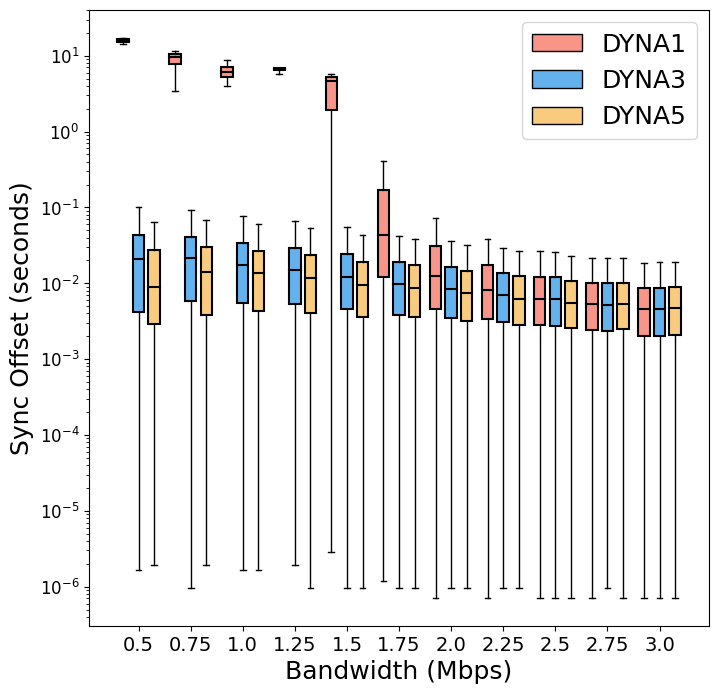

    Bandwidth                                              Set_1  \
0        0.50  [17.187885761260986, 17.202728986740112, 17.21...   
1        0.75  [11.472317934036255, 11.481640815734863, 11.49...   
2        1.00  [5.511585235595703, 5.511585235595703, 5.51170...   
3        1.25  [1.5952389240264893, 1.5965230464935303, 1.603...   
4        1.50  [0.8152320384979248, 0.8152320384979248, 0.788...   
5        1.75  [0.2616288661956787, 0.2616288661956787, 0.227...   
6        2.00  [0.012077093124389648, 0.012077093124389648, 0...   
7        2.25  [0.008368968963623047, 0.008368968963623047, 0...   
8        2.50  [0.0031533241271972656, 0.0031533241271972656,...   
9        2.75  [0.001107931137084961, 0.001107931137084961, 0...   
10       3.00  [0.007911920547485352, 0.006831169128417969, 0...   

                                                Set_2  \
0   [0.05182075500488281, 0.05182075500488281, 0.0...   
1   [0.0577089786529541, 0.0577089786529541, 0.002...   
2   [0.09326

In [ ]:
import pandas as pd
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

# 原始带宽列表
bandwidths = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 5, 10]

# 假设 all_differences_1, all_differences_2, 和 all_differences_3 已按带宽顺序准备好
# 创建 DataFrame，直接从 all_differences_1、all_differences_2 和 all_differences_3 中获取数据
df = pd.DataFrame({
    'Bandwidth': bandwidths,
    'Set_1': all_differences_1[::-1],
    'Set_2': all_differences_2[::-1],
    'Set_3': all_differences_3[::-1]
})

# 过滤掉 5 和 10 Mbps 的数据，并按带宽升序排列
df = df[df['Bandwidth'] < 5].sort_values('Bandwidth').reset_index(drop=True)

# 为 DataFrame 添加绘图位置和颜色
main_spacing = 5  # 每个带宽组之间的间隔
pair_offset = 1.5  # 每对箱体图内的偏移量
df['Position_1'] = [i * main_spacing + 1 for i in range(len(df))]  # Set 1 的位置
df['Position_2'] = [i * main_spacing + 1 + pair_offset for i in range(len(df))]  # Set 2 的位置
df['Position_3'] = [i * main_spacing + 1 + 2 * pair_offset for i in range(len(df))]  # Set 3 的位置
df['Color_1'] = '#f89588'  # Set 1 的颜色
df['Color_2'] = '#63b2ee'  # Set 2 的颜色
df['Color_3'] = '#f8cb7f'  # Set 3 的颜色

plt.figure(figsize=(8, 8))
boxprops = dict(linewidth=1.5, facecolor='white')
medianprops = dict(color='black', linewidth=1.5)
flierprops = dict(marker='.', markerfacecolor='red', markeredgecolor='red', markersize=0)
box_width = 1.1

# 使用 DataFrame 的数据绘图
positions = df['Position_1'].tolist() + df['Position_2'].tolist() + df['Position_3'].tolist()
combined_data_filtered = df['Set_1'].tolist() + df['Set_2'].tolist() + df['Set_3'].tolist()
colors = df['Color_1'].tolist() + df['Color_2'].tolist() + df['Color_3'].tolist()

# 绘制箱体图
boxplot = plt.boxplot(combined_data_filtered, patch_artist=True, positions=positions, 
                      boxprops=boxprops, medianprops=medianprops, flierprops=flierprops, 
                      widths=box_width, showfliers=True)

# 设置每个箱体的颜色
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# 自定义图例
legend_elements = [Patch(facecolor='#f89588', edgecolor='black', label='DYNA1'),
                   Patch(facecolor='#63b2ee', edgecolor='black', label='DYNA3'),
                   Patch(facecolor='#f8cb7f', edgecolor='black', label='DYNA5')]
plt.legend(handles=legend_elements, loc='upper right', fontsize=18)
plt.yscale('log')
# 设置 x 轴刻度，使标签位于每组三个箱体图的中间位置
plt.xticks([i * main_spacing + 1 + pair_offset for i in range(len(df))], 
           [f'{bw}' for bw in df['Bandwidth']], fontsize=14)
plt.yticks(fontsize=12)  # 设置 y 轴字体大小
# 设置标题和标签
plt.xlabel("Bandwidth (Mbps)", fontsize=18)
plt.ylabel("Sync Offset (seconds, log scale)", fontsize=18)
# plt.ylim(-0.005, 0.12)
#plt.tight_layout()

plt.savefig(r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\figures\methods\between_aqm_offset.eps")
plt.savefig(r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\figures\methods\between_aqm_offset.png")
# 显示图表
plt.show()

# 打印最终用于绘图的数据
print(df)


In [222]:
import csv
import os

# 指定每个 dps 值对应的完整目录路径
paths = {
    0.03: r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\cake_XDP_AIMD",
    0.7: r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\tc_control\result\cake",
    
}

# 初始化用于存储结果的列表
all_differences_1 = []
all_differences_2 = []

# 遍历每个 dps 值和对应的路径，并读取每个 CSV 文件的数据
for i, (dps, base_path) in enumerate(paths.items()):
    # 查找以 "haptic_video_offset" 开头的文件
    file_name = None
    for file in os.listdir(base_path):
        if file.startswith("haptic_video_offset") and file.endswith(".csv"):
            file_name = file
            break  # 找到第一个匹配的文件就停止

    if file_name:
        # 构建完整文件路径
        input_path = os.path.join(base_path, file_name)
        differences = []

        try:
            with open(input_path, "r", newline="") as f:
                reader = csv.reader(f)
                for row in reader:
                    # 将每行数据转换为 float 类型并添加到列表
                    differences.append([float(value) for value in row])

            # 根据当前 dps 值，将数据存储到对应的列表
            if i == 0:
                all_differences_1 = differences
            elif i == 1:
                all_differences_2 = differences

        except FileNotFoundError:
            print(f"File not found for dps {dps} at path {base_path}, skipping.")
    else:
        print(f"No file starting with 'haptic_video_offset' found in {base_path}")



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


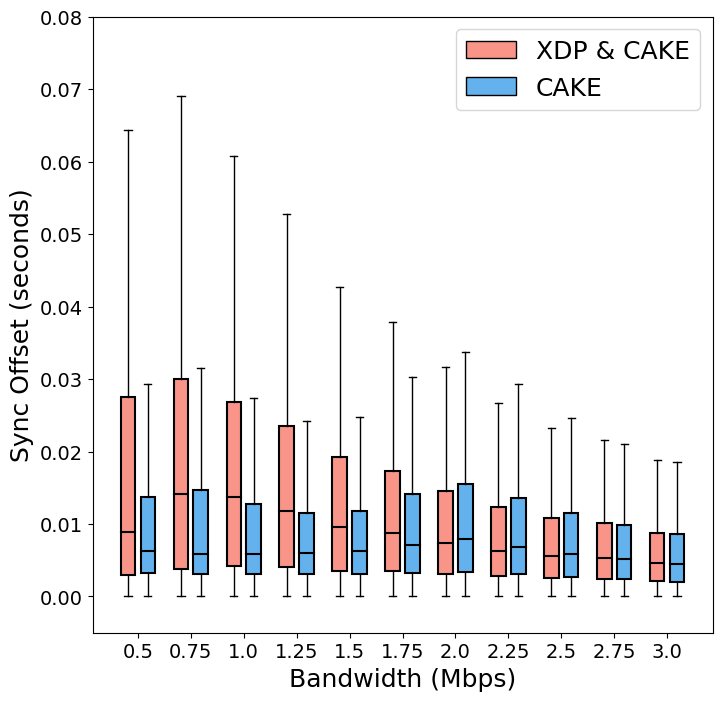

    Bandwidth                                              Set_1  \
0        0.50  [0.026292800903320312, 0.026292800903320312, 0...   
1        0.75  [0.02023792266845703, 0.02023792266845703, 0.0...   
2        1.00  [0.03384590148925781, 0.03384590148925781, 0.0...   
3        1.25  [0.01743173599243164, 0.01743173599243164, 0.0...   
4        1.50  [0.0158541202545166, 0.0158541202545166, 0.009...   
5        1.75  [0.014216184616088867, 0.014216184616088867, 0...   
6        2.00  [0.0182650089263916, 0.0182650089263916, 0.003...   
7        2.25  [0.0005571842193603516, 0.0004298686981201172,...   
8        2.50  [0.0007839202880859375, 0.0006577968597412109,...   
9        2.75  [0.0181429386138916, 0.0181429386138916, 0.000...   
10       3.00  [0.0026400089263916016, 0.0008690357208251953,...   

                                                Set_2  Position_1  Position_2  \
0   [0.025829076766967773, 0.025829076766967773, 0...           1         2.5   
1   [0.02318572998046

In [225]:
import pandas as pd
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

# 原始带宽列表
bandwidths = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 5, 10]

# 假设 all_differences_1 和 all_differences_2 已按带宽顺序准备好
# 创建 DataFrame，直接从 all_differences_1 和 all_differences_2 中获取数据
df = pd.DataFrame({
    'Bandwidth': bandwidths,
    'Set_1': all_differences_1[::-1],
    'Set_2': all_differences_2[::-1]
})

# 过滤掉 5 和 10 Mbps 的数据，并按带宽升序排列
df = df[df['Bandwidth'] < 5].sort_values('Bandwidth').reset_index(drop=True)

# 为 DataFrame 添加绘图位置和颜色
main_spacing = 4  # 每个带宽组之间的间隔
pair_offset = 1.5  # 每对箱体图内的偏移量
df['Position_1'] = [i * main_spacing + 1 for i in range(len(df))]  # Set 1 的位置
df['Position_2'] = [i * main_spacing + 1 + pair_offset for i in range(len(df))]  # Set 2 的位置
df['Color_1'] = '#f89588'  # Set 1 的颜色
df['Color_2'] = '#63b2ee'  # Set 2 的颜色

plt.figure(figsize=(8, 8))
boxprops = dict(linewidth=1.5, facecolor='white')
medianprops = dict(color='black', linewidth=1.5)
flierprops = dict(marker='.', markerfacecolor='red', markeredgecolor='red', markersize=0)
box_width = 1.1

# 使用 DataFrame 的数据绘图
positions = df['Position_1'].tolist() + df['Position_2'].tolist()
combined_data_filtered = df['Set_1'].tolist() + df['Set_2'].tolist()
colors = df['Color_1'].tolist() + df['Color_2'].tolist()

# 绘制箱体图
boxplot = plt.boxplot(combined_data_filtered, patch_artist=True, positions=positions, 
                      boxprops=boxprops, medianprops=medianprops, flierprops=flierprops, 
                      widths=box_width, showfliers=True)

# 设置每个箱体的颜色
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# 自定义图例
legend_elements = [Patch(facecolor='#f89588', edgecolor='black', label='XDP & CAKE'),
                   Patch(facecolor='#63b2ee', edgecolor='black', label='CAKE')]
plt.legend(handles=legend_elements, loc='upper right', fontsize=18)

# 设置 x 轴刻度，使标签位于每对箱体图的中间位置
plt.xticks([i * main_spacing + 1 + pair_offset / 2 for i in range(len(df))], 
           [f'{bw}' for bw in df['Bandwidth']], fontsize=14)

# 设置标题和标签
plt.xlabel("Bandwidth (Mbps)", fontsize=18)
plt.ylabel("Sync Offset (seconds)", fontsize=18)
plt.ylim(-0.005, 0.08)
plt.yticks(fontsize=14)

# 保存图表
plt.savefig(r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\figures\methods\cake_offset.eps")
plt.savefig(r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\figures\methods\cake_offset.png")

# 显示图表
plt.show()

# 打印最终用于绘图的数据
print(df)


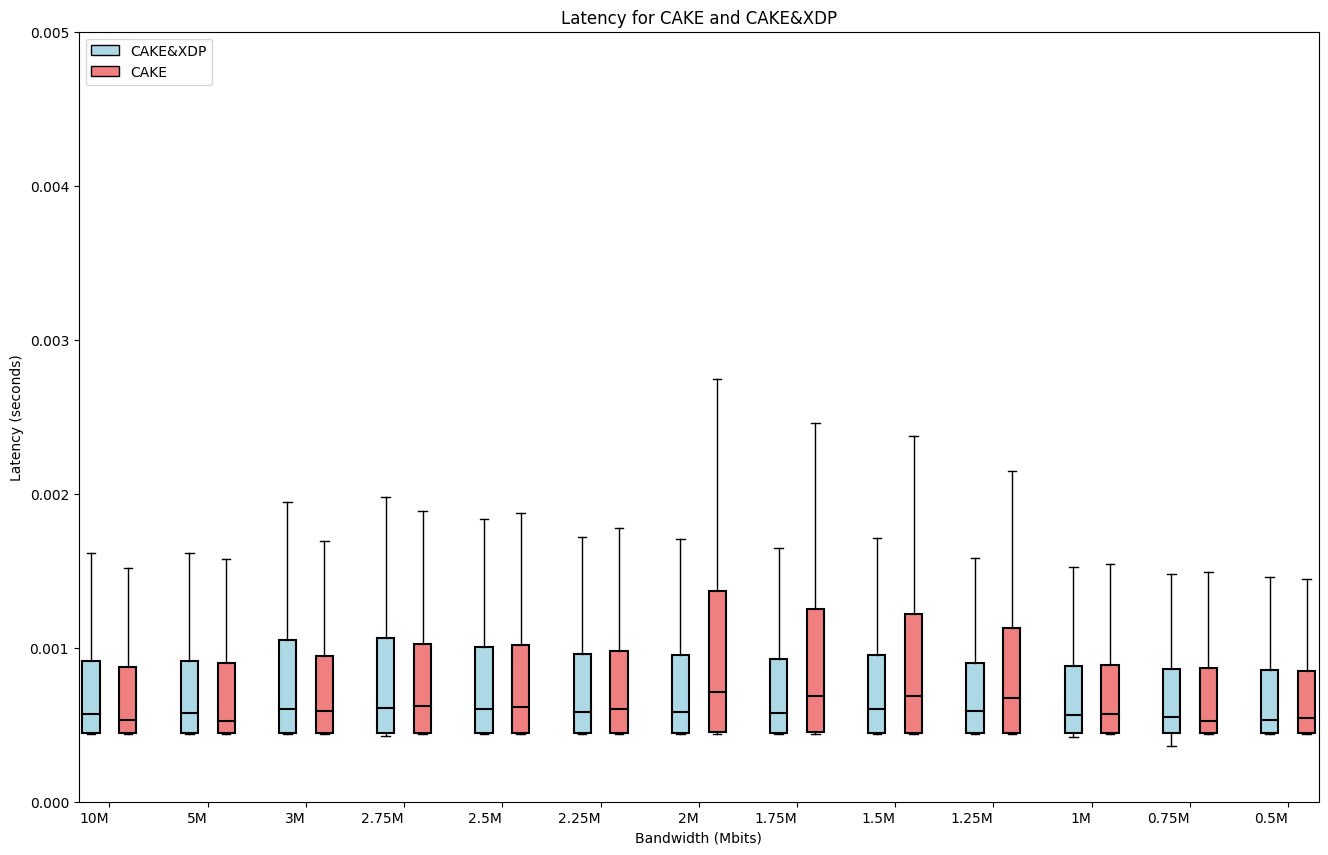

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# List of bandwidths for the filenames
bandwidths = [10, 5, 3, 2.75, 2.5, 2.25, 2, 1.75, 1.5, 1.25, 1, 0.75, 0.5]

# Initialize empty lists to store the 'latency' data from each file for both sets
latency_data_fq_codel = []
latency_data_codel = []

# Loop over each bandwidth to read the respective CSV files for both fq_codel and codel
for num in bandwidths:
    # File paths for the two sets of files
    with_XDP = fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\cake_XDP\haptic\result_df_haptic_{num}M.csv"
    without_XDP = fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\tc_control\result\cake\haptic\result_df_haptic_{num}M.csv"
    
    # Read the fq_codel CSV file
    try:
        df_fq_codel = pd.read_csv(with_XDP)
        # Filter out rows where status is 'lost' and only include rows with status 'Received'
        filtered_fq_codel = df_fq_codel[df_fq_codel['status'] == 'Received']
        # Extract the 'latency' column and append to the list
        latency_data_fq_codel.append(filtered_fq_codel['latency'])
    except FileNotFoundError:
        print(f"File {with_XDP} not found. Skipping.")
    
    # Read the codel CSV file
    try:
        df_codel = pd.read_csv(without_XDP)
        # Filter out rows where status is 'lost' and only include rows with status 'Received'
        filtered_codel = df_codel[df_codel['status'] == 'Received']
        # Extract the 'latency' column and append to the list
        latency_data_codel.append(filtered_codel['latency'])
    except FileNotFoundError:
        print(f"File {without_XDP} not found. Skipping.")

# Prepare to plot boxplots for both datasets
plt.figure(figsize=(16, 10))

# Combine data for plotting; each bandwidth has two boxplots side-by-side
combined_data = []
colors = []

# Create new positions with larger distances between different bandwidth groups
positions = []
main_spacing = 4  # Increased spacing between each bandwidth group
pair_offset = 1.5  # Offset to create a gap within each pair of boxplots

for i in range(len(bandwidths)):
    # For each bandwidth, add two positions: one for FQ_CoDel&XDP and one for FQ_CoDel
    positions.append(i * main_spacing + 1)  # First boxplot for this bandwidth
    positions.append(i * main_spacing + 1 + pair_offset)  # Second boxplot for this bandwidth

    # Append corresponding data
    combined_data.append(latency_data_fq_codel[i])
    combined_data.append(latency_data_codel[i])
    
    # Colors: fq_codel in blue and codel in orange
    colors.append('lightblue')  # fq_codel
    colors.append('lightcoral')  # codel

# Plotting the combined boxplots with increased width
boxprops = dict(linewidth=1.5, facecolor='white')  # Outline properties for boxplots
medianprops = dict(color='black', linewidth=1.5)  # Median line properties
flierprops = dict(marker='.', markerfacecolor='red', markeredgecolor='red', markersize=0)

# Set the width of the boxplots
box_width = 0.7

boxplot = plt.boxplot(combined_data, patch_artist=True, positions=positions, boxprops=boxprops,
                      medianprops=medianprops, flierprops=flierprops, widths=box_width, showfliers=True)

# Set colors for each box
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Create custom legend
legend_elements = [Patch(facecolor='lightblue', edgecolor='black', label='CAKE&XDP'),
                   Patch(facecolor='lightcoral', edgecolor='black', label='CAKE')]

# Add the legend to the plot
plt.legend(handles=legend_elements, loc='upper left')

# Adjust x-ticks to make labels appear in the middle of the pair of boxplots for each bandwidth
plt.xticks([i * main_spacing + 1 + pair_offset / 2 for i in range(len(bandwidths))], [f'{i}M' for i in bandwidths], ha='right')
plt.ylim(0,0.005)
# Set titles and labels
plt.title("Latency for CAKE and CAKE&XDP")
plt.xlabel("Bandwidth (Mbps)")
plt.ylabel("Latency (seconds)")

# Show the plot
plt.show()


C:\Users\Administrator\AppData\Local\Temp\ipykernel_20312\1627040614.py:42: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  q1 = pd.Series(data).quantile(0.25)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_20312\1627040614.py:43: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  q3 = pd.Series(data).quantile(0.75)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


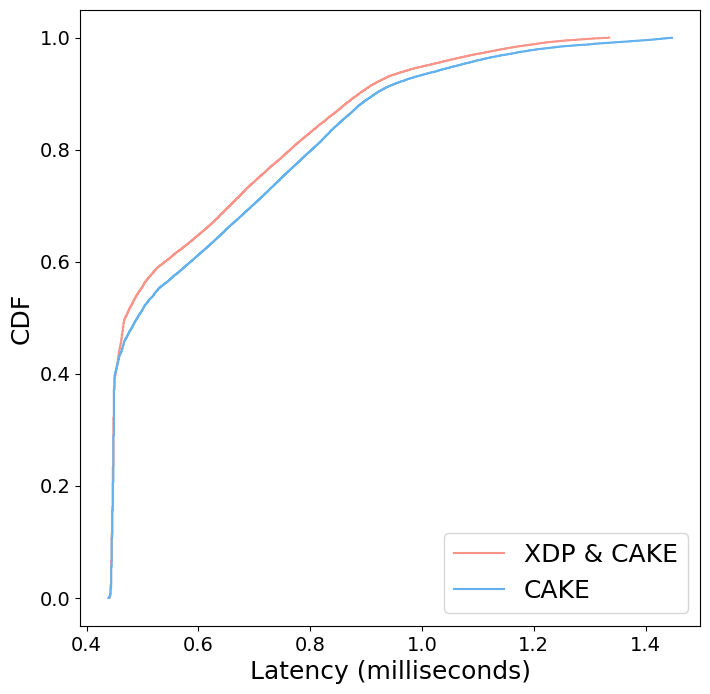

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# List of bandwidths for the filenames
bandwidths = [10, 5, 3, 2.75, 2.5, 2.25, 2, 1.75, 1.5, 1.25, 1, 0.75, 0.5]

# Dictionary to store the data for each path
paths_data = {
    "Path_1": [],
    "Path_2": [],
    "Path_3": [],
    "Path_4": [],
    "Path_5": []
}

# Paths for each dataset (adjust paths as needed)
base_paths = [
    
    # fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_DYNA\haptic\0.02\result_df_haptic_{num}_0.02_0.01.csv",
    
    fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\cake_XDP_AIMD\haptic\result_df_haptic_{num}_0.7_0.01.csv",
    fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\tc_control\result\cake\haptic\result_df_haptic_{num}M.csv",
    # fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_DYNA\haptic\0.04\result_df_haptic_{num}_0.04_0.01.csv",
    # fr"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_DYNA\haptic\0.05\result_df_haptic_{num}_0.05_0.01.csv",
]

# Read and store latency data for each path
for path_key, base_path in zip(paths_data.keys(), base_paths):
    for num in bandwidths:
        file_path = base_path.format(num=num)
        
        # Read the CSV file and filter by 'Received' status
        try:
            df = pd.read_csv(file_path)
            filtered_data = df[df['status'] == 'Received']['latency'] * 1000  # Convert latency to ms
            paths_data[path_key].extend(filtered_data)
        except FileNotFoundError:
            print(f"File {file_path} not found. Skipping.")

# Function to remove outliers
def remove_outliers(data):
    q1 = pd.Series(data).quantile(0.25)
    q3 = pd.Series(data).quantile(0.75)
    iqr = q3 - q1
    return [x for x in data if (x >= q1 - 1.5 * iqr) and (x <= q3 + 1.5 * iqr)]

# Function to calculate CDF values
def compute_cdf(data):
    sorted_data = sorted(data)
    cdf = [i / len(sorted_data) for i in range(len(sorted_data))]
    return sorted_data, cdf

# Plotting the CDFs for each path after outlier removal
plt.figure(figsize=(8, 8))
labels = ['XDP & CAKE', 'CAKE', '', '', '']
colors = ['#f89588', '#63b2ee', '#f8cb7f']
for i, (path_key, color) in enumerate(zip(paths_data.keys(), colors)):
    # Remove outliers and compute CDF
    cleaned_data = remove_outliers(paths_data[path_key])
    sorted_data, cdf = compute_cdf(cleaned_data)
    
    # Plot the CDF for the current path
    plt.plot(sorted_data, cdf, label=labels[i], color=color, linestyle='-')

# Labels and legend
plt.xlabel("Latency (milliseconds)", fontsize=18)
plt.ylabel("CDF", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=18)

plt.savefig(r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\figures\methods\cake_haptic_CDF.eps")
plt.savefig(r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\figures\methods\cake_haptic_CDF.png")
# Show the plot
plt.show()


In [53]:
import os
import re
import shutil

# 源文件夹路径
source_folder = r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_AIMD\haptic"

# 创建正则表达式模式，匹配包含整数和浮点数的文件名，并捕获第二个浮点数
pattern = re.compile(r'.*_[+-]?\d+(\.\d+)?_(\d+\.\d+)_\d+(\.\d+)?M?\..*')

# 遍历源文件夹中的文件
for filename in os.listdir(source_folder):
    # 匹配文件名
    match = pattern.match(filename)
    if match:
        # 提取用于分类的数值（即第二个浮点数，例如 0.03）
        category_value = match.group(2)
        
        # 创建分类文件夹路径
        target_folder = os.path.join(source_folder, category_value)
        
        # 如果文件夹不存在则创建
        if not os.path.exists(target_folder):
            os.makedirs(target_folder)
        
        # 移动文件到对应分类文件夹
        source_file = os.path.join(source_folder, filename)
        target_file = os.path.join(target_folder, filename)
        shutil.move(source_file, target_file)
        print(f"Moved {filename} to {target_folder}")


Moved latency_and_loss_stats_0.5_0.5_0.01.txt to C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_AIMD\haptic\0.5
Moved latency_and_loss_stats_0.5_0.6_0.01.txt to C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_AIMD\haptic\0.6
Moved latency_and_loss_stats_0.5_0.7_0.01.txt to C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_AIMD\haptic\0.7
Moved latency_and_loss_stats_0.5_0.8_0.01.txt to C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_AIMD\haptic\0.8
Moved latency_and_loss_stats_0.5_0.9_0.01.txt to C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_AIMD\haptic\0.9
Moved latency_and_loss_stats_0.75_0.5_0.01.txt to C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\XDP_tc_control\result\codel_XDP_AIMD\haptic\0.5
Moved latency_and_loss_stats_0.75